### Autora: Priscila Gutierres (priscila.gutierres@usp.br)
Nesse notebook iremos fazer uma análise exploratória do dataset e por fim aplicar o método KNN para fazer a análise dos dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [2]:
income = pd.read_csv('adult.csv')

#### Primeiramente, iremos analisar o dataframe sem tratamento algum, apenas para ter uma ideia sobre ele, apenas iremos limpar os valores nulos
#### Por questões de simplicidade, numa primeira abordagem apenas tiramos os valores nulos. Em outra, poderíamos escolher colocar a média dos valores da coluna (como em idade, por exemplo) ou a mediana (dependendo da conveniência) para preencher esses valores.


In [3]:
income = income.dropna(how='all')
income.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
income.tail()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
48841,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


### Correlações entre algumas  features correlações entre as features categóricas
#### Iremos analisar algumas features categóricas em busca de correlação entre elas e a quantidade de horas trabalhada
#### e o gênero, por exemplo

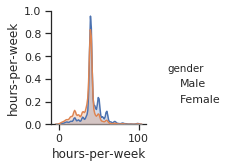

In [5]:
income['income'] = income['income']
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(income, hue="gender" ,vars=['hours-per-week'])

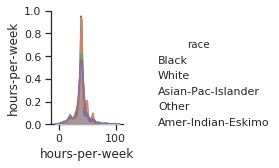

In [6]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(income, hue="race" ,vars=['hours-per-week'])

#### Agora, iremos limpar alguns dados e analisar algumas propriedades estatísticas básicas

#### Vamos remover valores nulos e também converter valores categóricos que serão usados em variáveis ordinais. Parece razoável assumir que a classe trabalhadora, etnia e o gênero (infelizmente) influenciam diretamente a renda de uma pessoa, portanto para uma primeira aproximação, como vamos ver adiante, parece razoável o uso desses dados.

##### Para tanto, definimos:
## Race:
#####    White: 0
#####    Black: 1
#### Asian-Pac-Islander: 2
#### Amer-Indian-Eskimo: 3
#### Other: 4
## Gender
####  Male: 0
#### Female: 1
## Workclass:
#### Private: 0
####  Local-gov: 1
#### Self-emp-inc: 2

In [7]:
dic_gender = {'Male':0,'Female':1}
dic_race = {'Black': 1, 'White':0, 'Asian-Pac-Islander': 2, 'Amer-Indian-Eskimo':3, 'Other':4}
dic_workclass = {'Private':0,'Local-gov':1, 'Self-emp-inc': 2, '?':3, 'Self-emp-not-inc':4, 'Federal-gov': 5, 'State-gov':6, \
                'Without-pay':7, 'Never-worked':8}
income = income.replace({"race": dic_race})
income = income.replace({"gender":dic_gender})
income = income.replace({"workclass": dic_workclass})

##### Para visualizar melhor a distribuição de alguns dados, Podemos fazer um histograma.  Por exemplo, da idade do nosso conjunto de dados

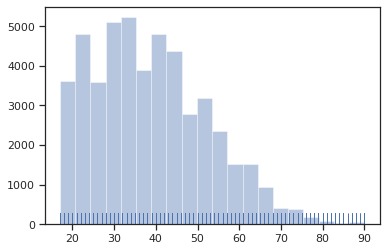

In [8]:
sns.distplot(income['age'].values, bins=20, kde=False, rug=True);

In [9]:
dropcols = ['fnlwgt','education', 'educational-num','marital-status','occupation','relationship', \
          'capital-loss','native-country','capital-gain']
for item in dropcols:
    del income[item]

    
    



##### trata as features para serem usadas no(s) modelo(s)

In [10]:
income['income'] = income['income'].str.replace('<=50K', '0', regex=False)
income['income'] = income['income'].str.replace('>50K', '1', regex=False)
y = income['income'].values.astype(int)

del income['income']
X = income.values.astype(int)
print(X)

[[25  0  1  0 40]
 [38  0  0  0 50]
 [28  1  0  0 40]
 ...
 [58  0  0  1 40]
 [22  0  0  0 20]
 [52  2  0  1 40]]


##### Devido ao tamanho reduzido do dataset, optou-se por dividir o conjunto de dados em apenas um conjunto de treino e teste
##### e não em treino, teste e validação.
#### Também optou-se em usar uma seleção aleatória para esse conjunto, afim de verificar a performace do modelo knn com n_neighbors=3 comparado com knn n_neighbors = 7  
#### A comparação entre os modelos foi inspirada (e utilizou código presente) em exemplo presente na documentação do scikit-learn.

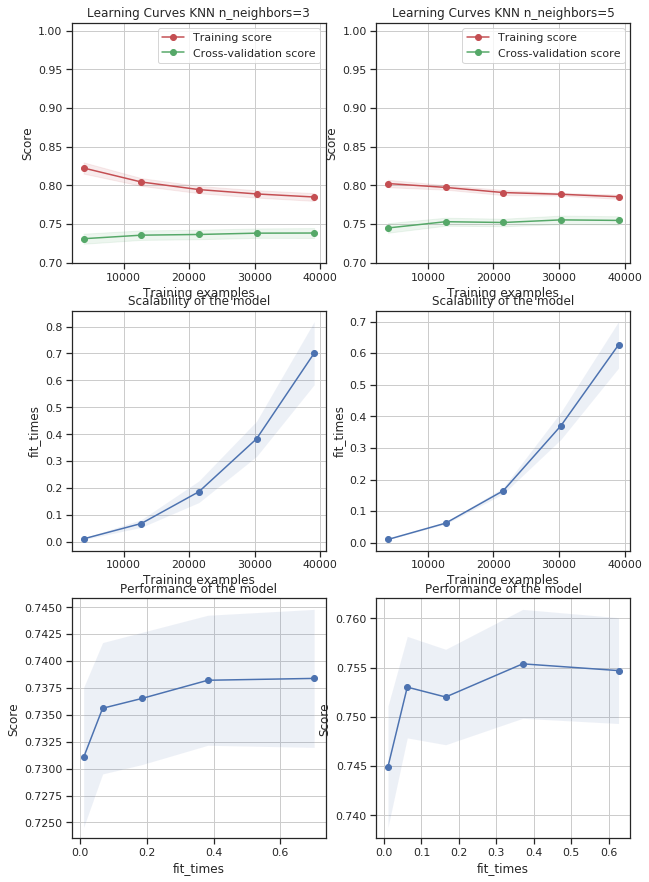

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves KNN n_neighbors=3"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2)

estimator =KNeighborsClassifier(n_neighbors=3)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves KNN n_neighbors=5"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator =KNeighborsClassifier(n_neighbors=7)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

#### Como observamos, o número de vizinhos não aumenta a  acurácia do método de forma significativa. Por curiosidade, podemos testar esse modelo com o Random Forest, por exemplo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves KNN n_neighbors=3"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2)

estimator = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves Random Forest"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator =KNeighborsClassifier(n_neighbors=7)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

###### Para uma análise simplificada como efetuada, obtivemos resultados satisfatórios com ambos os métodos, que mostraram acurácia
###### relativamente parecida para os dois casos de comparação testados.
###### Muitas melhorias futuras podem ser aplicadas para a análise desse dataset:
###### avaliar quais variáveis são correlacionadas ao ganho de capital, retirar outliers, etc.